# Part Two

In [1]:
def decompress_strat(num_batt: int, strat: {int: float}):
    return [
        (prob, intToStrat(num_batt, strat))
        for strat, prob in strat.items()
    ]

def compress_strat(profile: [(float, [bool])]):
    return {
        stratToInt(strat): prob
        for prob, strat in profile
    }

In [2]:
from part_one import *
from collections import defaultdict 
from tqdm import tqdm

def fictitious_play(num_batt: int, 
                    att_res: int, 
                    def_res: int, 
                    att_prof: [(float, [bool])], 
                    def_prof: [(float, [bool])], 
                    batt_values: [int],
                    t: int
                    ):
    asserts(num_batt, att_res, def_res, att_prof, batt_values)
    asserts(num_batt, att_res, def_res, def_prof, batt_values)  
    for _, att_strat in att_prof:
        assert len(att_strat) == num_batt
        assert sum(att_strat) == att_res
    for _, def_strat in def_prof:
        assert len(def_strat) == num_batt
        assert sum(def_strat) == def_res
    
    flattened_att = weighted_sum_of_lists(att_prof)
    flattened_def = weighted_sum_of_lists(def_prof)
    
    attacker_updates = []
    defender_updates = []
    
    attacker_flat_strats = [flattened_att.copy()]
    defender_flat_strats = [flattened_def.copy()]
    
    for i in range(1, t): # first round is just choosing strategies
        attacker_counter = generate_perfect_attacker_flat(num_batt, att_res, flattened_def, batt_values)
        defender_counter = generate_perfect_defender_flat(num_batt, def_res, flattened_att, batt_values)
        
        attacker_updates.append(stratToInt(attacker_counter))
        defender_updates.append(stratToInt(defender_counter))
        
        for j in range(num_batt):
            flattened_att[j] = (flattened_att[j] * i + attacker_counter[j]) / (i + 1)
            flattened_def[j] = (flattened_def[j] * i + defender_counter[j]) / (i + 1)
            
        attacker_flat_strats.append(flattened_att.copy())
        defender_flat_strats.append(flattened_def.copy())
    
    attacker_compressed_prof = defaultdict(lambda : 0)
    defender_compresed_prof = defaultdict(lambda : 0)
    multiplier = 1
    
    for i in range(t-1, 0, -1):
        attacker_compressed_prof[attacker_updates[i-1]] += multiplier / i
        defender_compresed_prof[defender_updates[i-1]] += multiplier / i
        multiplier *= (i-1)/i
    
    for strat, prob in compress_strat(att_prof).items():
        attacker_compressed_prof[strat] += prob * multiplier
    
    for strat, prob in compress_strat(def_prof).items():
        defender_compresed_prof[strat] += prob * multiplier
        
    return {
        "attacker": {
            "compressed_final": attacker_compressed_prof,
            "flattened": attacker_flat_strats
        },
        "defender": {
            "compressed_final": defender_compresed_prof,
            "flattened": defender_flat_strats
        }
    }

In [3]:
from scipy.special import binom

def generate_equal_strats(num_batt: int, num_of_resources: int):
    result = []
    prob = 1/ binom(num_batt, num_of_resources)
    for i in range(2**num_batt):
        strat = intToStrat(num_batt, i)
        if sum(strat) == num_of_resources:
            result.append((prob, strat))
    return result
    
    
def generate_2_strats(num_batt: int, num_of_resources: int):
    result = []
    prob = 1/2
    result.append((prob, [1] * num_of_resources + [0] * (num_batt - num_of_resources)))
    result.append((prob, [0] * (num_batt - num_of_resources) + [1] * num_of_resources))
    return result

# 2.1

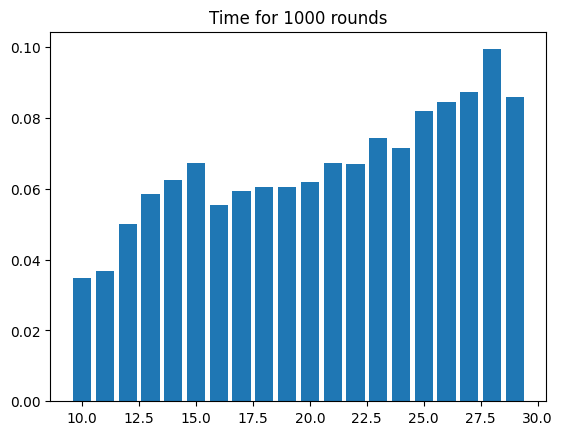

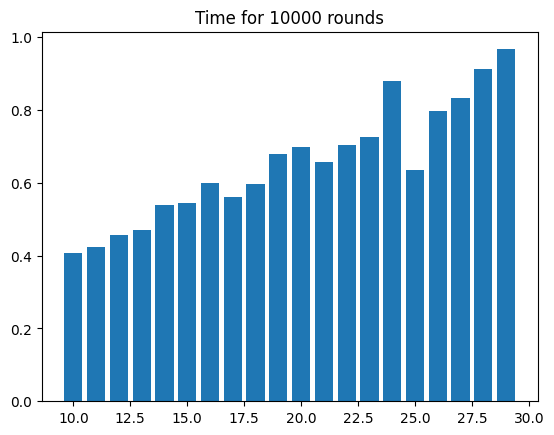

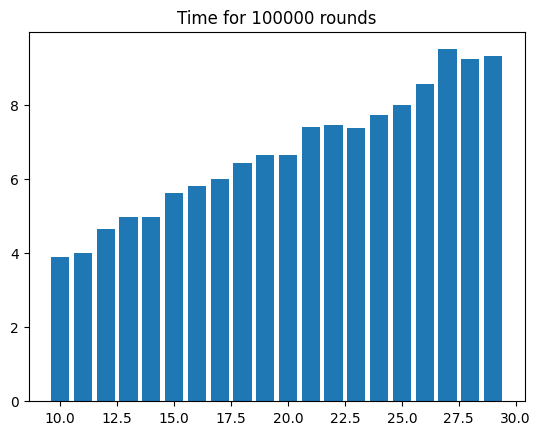

In [4]:
import timeit
import matplotlib.pyplot as plt

ts = [1000, 10000, 100000]
num_of_batts_s = range(10, 30)
batt_val_gen = list(range(2, 6)) * 10

timeit.default_timer()

for t in ts:
    res = []
    for num_of_batts in num_of_batts_s:
        batt_val = batt_val_gen[:num_of_batts]
        att_res = num_of_batts // 3
        def_res = num_of_batts // 3 * 2
        att_prof = generate_2_strats(num_of_batts, att_res) 
        def_prof = generate_2_strats(num_of_batts, def_res)
        start = timeit.default_timer()
        fictitious_play(num_of_batts, att_res, def_res, att_prof, def_prof, batt_val , t)
        stop = timeit.default_timer()
        res.append(stop - start)
        #print(f"Time for {num_of_batts} batts and {t} rounds: {stop - start}")
    plt.bar(num_of_batts_s, res, label = f"{t} rounds")
    plt.title(f"Time for {t} rounds")
    plt.show()
        



Złożoność obliczeniowa jest liniowa względem ilośi pól bitew.

# 2.2

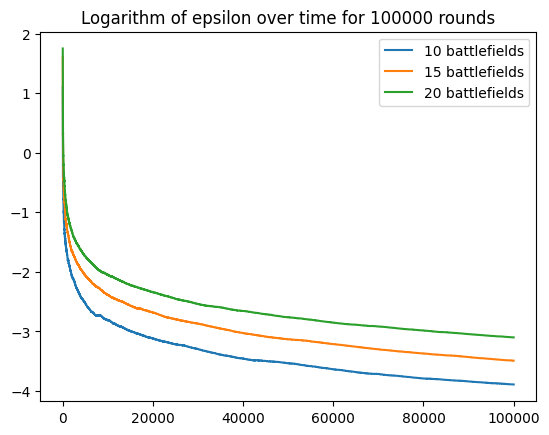

In [21]:
from math import log2
from cmath import log, log10
import matplotlib.pyplot as plt
from tqdm import tqdm


num_of_batts_s = [10, 15, 20]
batt_val_gen = list(range(2, 6)) * 10
t = 100000

def run():
    for num_of_batts in num_of_batts_s:
        batt_val = batt_val_gen[:num_of_batts]
        att_res = num_of_batts // 2
        def_res = num_of_batts // 3 * 2
        att_prof = generate_2_strats(num_of_batts, att_res)
        def_prof = generate_2_strats(num_of_batts, def_res)
        fp = fictitious_play(num_of_batts, att_res, def_res, att_prof, def_prof, batt_val , t)
        
        epsilons = [epsilons_flat(num_of_batts, att_res, def_res, ap, dp, batt_val)
            for ap, dp in zip(fp["attacker"]["flattened"], fp["defender"]["flattened"])]
        
        epsilons = [(a+b)/2 for a, b in epsilons]
        
        plt.plot([log(a) for a in epsilons], label = f"{num_of_batts} battlefields")
        
    plt.legend()
    plt.title(f"Logarithm of epsilon over time for {t} rounds")
    plt.show()
        
        
run()

Logarytm epsilona zbiega do zera. WYkres wypłaszcza się jednak, co sugeruje, że epsilon zbiega wolniej niż wykładniczo.


# 2.3

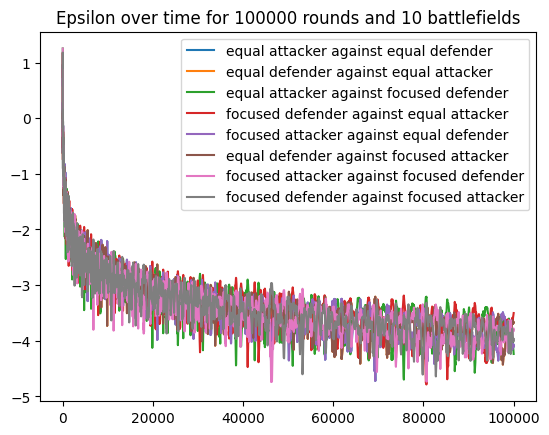

In [19]:
from itertools import product

num_of_batts = 10
batt_val = batt_val_gen[:num_of_batts]
att_res = num_of_batts // 2
def_res = num_of_batts // 3 * 2
t = 100000
att_strats = [
    (generate_equal_strats(num_of_batts, att_res), "equal attacker"), 
    (generate_2_strats(num_of_batts, att_res), "focused attacker")
]
def_strats = [
    (generate_equal_strats(num_of_batts, def_res), "equal defender"),
    (generate_2_strats(num_of_batts, def_res), "focused defender")
]

for (att_prof, att_name), (def_prof, def_name) in product(att_strats, def_strats):
    
    fp = fictitious_play(num_of_batts, att_res, def_res, att_prof, def_prof, batt_val , t)
    
    att_epsilons, def_epsilons = list(zip(*[
        epsilons_flat(num_of_batts, att_res, def_res, ap, dp, batt_val)
        for ap, dp in zip(fp["attacker"]["flattened"], fp["defender"]["flattened"])
    ]))

    plt.plot([log(a) for a in att_epsilons], label = f"{att_name} against {def_name}")
    plt.plot([log(d) for d in def_epsilons], label = f"{def_name} against {att_name}")
    
plt.legend()
plt.title(f"Epsilon over time for {t} rounds and {num_of_batts} battlefields")
plt.show()


Żadna ze strategii nie daje widocznie lepszych wynikóœ od pozostałych.

# 2.4

W latexu.